## Exploring Pytorch and JAX

Cite like this [[1](#ref-1)]. In this post, we hope to concisely introduce two prominent frameworks for deep learning: Pytorch and JAX. 

We also hoped to cover Tensorflow. But for reasons unclear to us, we were unable to install Tensorflow both with Python 3.12 and Python 3.11. Given the simultaneous development of Tensorflow and JAX within Google, and the recent popularity of JAX, I wouldn't be surprised if Tensorflow is heading towards deprecation in the future. For completeness, it is worth noting that Tensorflow is the oldest among the three, being first introduced in 2011.

Pytorch was first introduced in 2016 by Adam Paszke and Soumith Chintala along with others at FAIR [[1](#ref-1)]. Some features that made Pytorch stand out over Tensorflow when it was introduced are: dynamic computational graph, pythonic nature, and extensive ecosystem - notably torchvision, torchaudio, and torchtext.

JAX ("just after execution") was first introduced in 2018 by Roy Frostig, Matthew James Johnson, and Chris Leary at Google Brain [[2](#ref-2)]. Some unique features of JAX include: jit compilation ("just in time compilation"), XLA ("accelerated linear algebra"), autovectorization & large data parallelism (via `vmap` and `pmap` respectively). JAX is known for its computational efficiency on hardware accelerators like GPUs and TPUs. 

What both Pytorch and JAX have in common is automatic differentiation (`autograd` in pytorch, and just `grad` in JAX). The execution speed however is faster in JAX since it benefits from autovectorization and jit compilation abilities mentioned earlier. On the other hand, what makes Pytorch and JAX fundamentally different as frameworks is the programming paradigm they use: Pytorch is object-oriented, while JAX is functional.

Let us look at some examples. 




<!-- ### PyTorch
Developed by FAIR, PyTorch is celebrated for its ease of use, flexibility, and dynamic computation graph. It allows for intuitive model development and debugging, making it a favorite among researchers and developers for prototyping and experimentation.
**Unique Features:**
- **Dynamic Computation Graph:** PyTorch constructs the computation graph on-the-fly. This feature, known as eager execution, allows for more interactive and dynamic model development [14].
- **Pythonic Nature:** PyTorch's design is highly pythonic, making it easy to learn and use, especially for those already familiar with Python [14].
- **Extensive Ecosystem:** With libraries like torchvision, torchaudio, and torchtext, PyTorch provides a rich ecosystem for various applications, from computer vision to natural language processing [14].
### JAX
JAX, developed by Google, is a framework that extends NumPy with automatic differentiation and GPU/TPU acceleration. It is particularly suited for high-performance machine learning research and scientific computing.
**Unique Features:**
- **Functional Programming Style:** JAX encourages pure functions and immutability, aligning with functional programming principles. This approach can simplify certain types of mathematical modeling and transformation composition [12][13]. -->
<!-- - **Composable Transformations:** JAX provides powerful function transformations like `grad`, `jit`, and `vmap` for differentiation, just-in-time compilation, and vectorization, respectively [12][13].
- **Performance:** Leveraging XLA (Accelerated Linear Algebra) for compiling and optimizing computations, JAX can achieve significant performance improvements, especially on accelerators like GPUs and TPUs [13][18].
## Summary Comparison
- **Ease of Use:** PyTorch is often praised for its intuitive and pythonic API, making it easier for beginners and for rapid prototyping. JAX, with its functional programming model, might have a steeper learning curve but offers powerful capabilities for those familiar with its paradigm [14][18].
- **Performance:** JAX is designed for high-performance computing, leveraging JIT compilation and XLA. PyTorch also offers performance optimizations but might not match JAX's speed in certain scenarios, especially on TPUs [13][18].
- **Ecosystem and Community:** PyTorch benefits from a larger community and a more extensive ecosystem of libraries and tools. JAX, while having a smaller ecosystem, is rapidly growing and includes specialized libraries like Flax and Haiku for neural network development [14][18].
In conclusion, the choice between PyTorch and JAX is a trade-off between versatility and performance optimization. PyTorch is considered more accessible and versatile for a wide range of applications, while JAX is well-known for its performance optimization and functional programming features - suitable for large-scale ML and scientific computing in particular [][] -->


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot

In [9]:
# Define neural net architecture class (784+128+10 neurons, where the second and third layer are fully connected)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
net = Net()
# Load dataset (FashionMNIST from torchvision)
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
trainloader = DataLoader(training_data, batch_size=64, shuffle=True)

# Choose loss function and optimizer (cross-entropy loss, stochastic gradient descent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the network
for epoch in range(2):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data               # get data stored as [inputs, labels] in trainloader
        optimizer.zero_grad()               # zero the parameter gradients
        outputs = net(inputs)               # forward pass
        loss = criterion(outputs, labels)   # compute loss function
        loss.backward()                     # backward pass
        optimizer.step()                    # update weights

In [13]:
# Load test dataset
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Calculate the accuracy on the test dataset
accuracy = evaluate_model(net, test_loader)
print(f'Accuracy of the model on the test images: {accuracy}%')

Accuracy of the model on the test images: 57.59%


So we've trained a simple neural net with two fully connected layers (784+128+10 neurons) on FashionMNIST (clothes classification dataset in torchvision), with a seemingly lacklustre accuracy of 57.59 percent. In any case, we would like some visualization of the trained weights. For this, we will try two methods: matplotlib and torchviz. Let's first look at matplotlib.

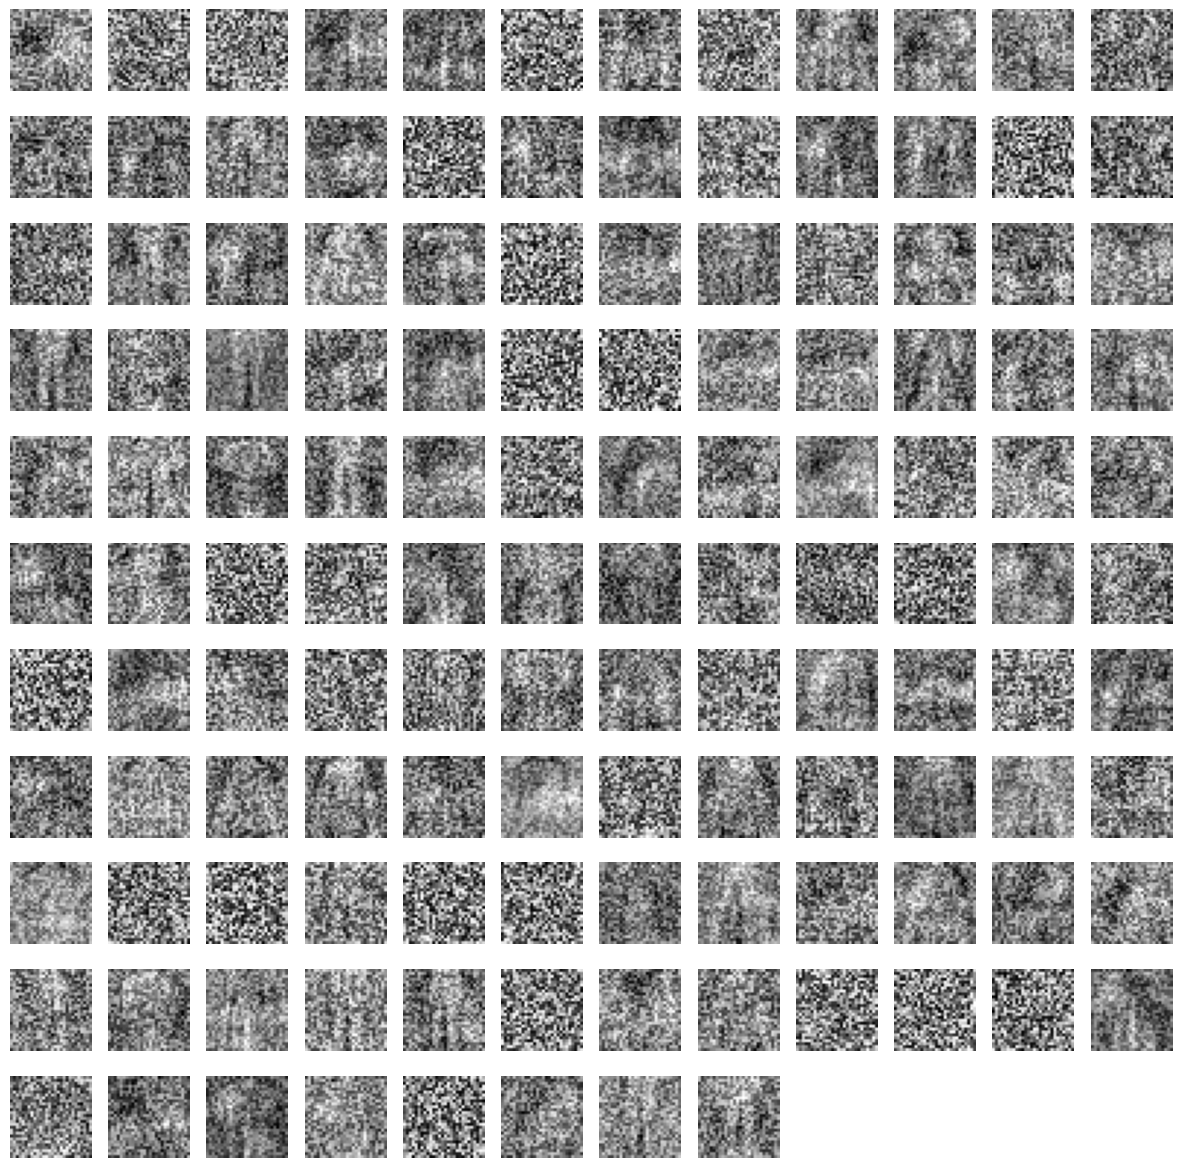

In [21]:
# Extract weights that connect to first fully connected layer 'fc1' (128x784 matrix)
weights = net.fc1.weight.data.numpy()
# Present weights matrix as 128 images of 28x28 resolution
# num_x = int(np.ceil(np.sqrt(len(weights))))  
# num_y = num_x                                
fig, axes = plt.subplots(11, 12, figsize=(15, 15)) 
for i, ax in enumerate(axes.flat):  
    if i < len(weights):    
        ax.imshow(weights[i].reshape(28, 28), cmap='gray')  
    ax.axis('off')
# plt.tight_layout()
plt.show()

What we see above is a matplotlib visualization of the trained weight matrix for the first fully connected layer (with 128 neurons, each getting 784 = 28*28 weights, visualized as grayscale images). Let us now try torchviz, a network visualization tool for pytorch.

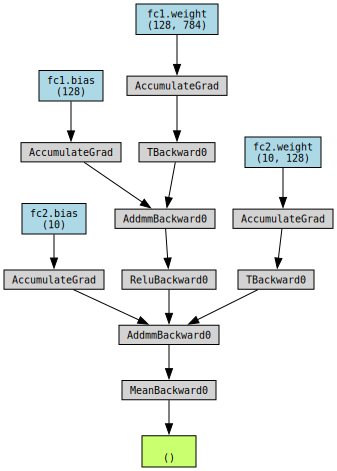

In [12]:
# Create a dummy input tensor that matches the input shape of the network
dummy_input = torch.randn(1, 784)
# Perform a forward pass to get the output
output = net(dummy_input)
# Visualize the computational graph
graph = make_dot(output.mean(), params=dict(net.named_parameters()))
graph.render('network_graph', format='png')  # This will save the graph as a PNG image
graph

Above is a torchviz visualization of the neural net flow : two fully connected layers fc1 and fc2, fc1 has 128 neurons each with 784 weights, and fc2 has 10 neurons each with 128 weights. each input is a 28*28 image.

Let us now try to implement the same example in JAX.

In [14]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax

# Define neural net architecture class
class SimpleNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = jnp.reshape(x, (x.shape[0], -1))  # Flatten input
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x
# Define functions to embed the train & test data into numpy arrays
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
def prepare_dataloader(dataset, *args, **kwargs):
    return DataLoader(dataset, collate_fn=numpy_collate, *args, **kwargs)
# Load train & test data (FashionMNIST from torchvision again)
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
trainloader = prepare_dataloader(training_data, batch_size=64, shuffle=True)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
testloader = prepare_dataloader(test_data, batch_size=64, shuffle=False)

# Define cross-entropy loss
def cross_entropy_loss(*, logits, labels):
    labels_onehot = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(labels_onehot * jax.nn.log_softmax(logits), axis=-1))
# Define update step
@jax.jit
def train_step(state, batch):
    inputs, labels = batch
    inputs = jnp.array(inputs).reshape(inputs.shape[0], -1)
    labels = jnp.array(labels)
    def loss_fn(params):
        logits = SimpleNN().apply({'params': params}, inputs)
        loss = cross_entropy_loss(logits=logits, labels=labels)
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss, logits
    
# Train the network
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
model = SimpleNN()
params = model.init(init_rng, jnp.ones([1, 28 * 28]))['params']

tx = optax.sgd(learning_rate=0.001, momentum=0.9)   # Stochastic Gradient Descent optimizer provided by optax
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

for epoch in range(2):
    for batch in trainloader:
        state, loss, logits = train_step(state, batch)

# Evaluate the network's performance
def accuracy(logits, labels):
    return jnp.mean(jnp.argmax(logits, -1) == labels)
@jax.jit
def eval_step(params, batch):
    inputs, labels = batch
    inputs = jnp.array(inputs).reshape(inputs.shape[0], -1)
    labels = jnp.array(labels)
    logits = model.apply({'params': params}, inputs)
    return accuracy(logits, labels)
accuracies = []
for batch in testloader:
    accuracies.append(eval_step(state.params, batch))
print('Test set accuracy:', np.mean(accuracies))


Test set accuracy: 0.79677546


Interestingly, while Pytorch trained with a poor 57.6 percent test accuracy, JAX got 79.7 percent test accuracy. This is despite using the same optimizer (SGD with learning rate 0.001 and momentum 0.9) and the same loss function (cross-entropy). So either the test dataset is created somewhat differently (or) JAX is superior in accuracy to Pytorch. I don't know if the latter is true in general, but I guess we'll learn more as I continue experimenting in the future.

Let's go ahead and visualize like before. This time we can do exactly what we did with matplotlib earlier, however we cannot use torchviz. In my exploration, I didn't come across a simple equivialent of torchviz in JAX. Leaving that aside, let's go ahead and visualize the weights.

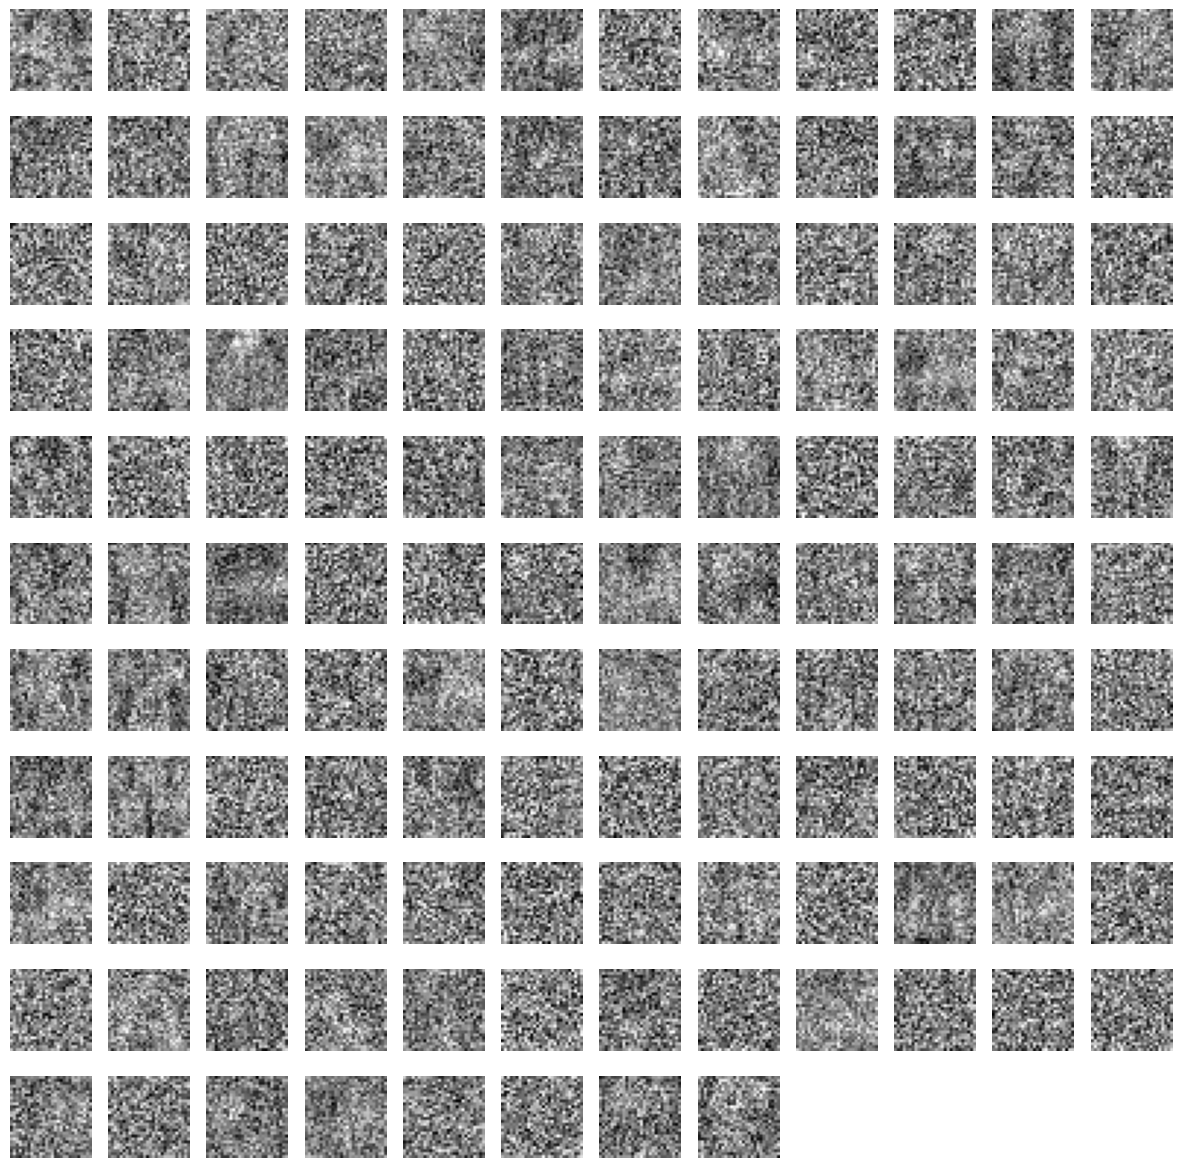

In [20]:
weights = state.params['Dense_0']['kernel']
# Transpose the weights to match the input shape for visualization
weights = weights.T

# Reshape and plot the weights
fig, axes = plt.subplots(11, 12, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    if i < weights.shape[0]:  # Check to avoid index error
        weight = weights[i].reshape(28, 28)  # Reshape the weight to 28x28
        ax.imshow(weight, cmap='gray')
    ax.axis('off')
#plt.tight_layout()
plt.show()

Interesting. While there isn't too much we learn at this low a resolution, if we carefully compare the structure of the Pytorch and JAX weights, we see that JAX has more fine-grained variation in the trained weights, which from a distance looks more random than the pytorch weights. But clearly they've learnt different weights, and JAX's superior accuracy might be stemming from its ability to pick up more fine-grained spatial variations in the input images.

### References  
[1] <a id="ref-1"></a> [https://proceedings.neurips.cc/paper_files/paper/2019/file/bdbca288fee7f92f2bfa9f7012727740-Paper.pdf](https://proceedings.neurips.cc/paper_files/paper/2019/file/bdbca288fee7f92f2bfa9f7012727740-Paper.pdf)  
[2] <a id="ref-2"></a> [https://mlsys.org/Conferences/doc/2018/146.pdf](https://mlsys.org/Conferences/doc/2018/146.pdf)  
<!-- use two extra spaces at end of each line for line break -->
